# Домашнее задание к занятию «Сингулярный спектральный анализ»

***Цель:***
    Провести анализ с помощью SSA любом из временных рядов с первого занятия. Посмотреть на результаты с разными длинами окон. Обязательно визуализировать результаты, аналогично материалу с занятия.

Поскльку тема для меня нова, воспроизведем пошагово всё, что делали на лекции, но уже для выбранного временного ряда.

Для начала применим настройки:

In [1]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

### 1. Визуальный анализ ряда

Посмотрим на ряд, который мы выбрали: это авиаперевозки в тысячах пассажиров:

In [2]:
airlines = pd.read_csv("international-airline-passengers.csv")
airlines

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Супер. Теперь посмотрим на тренд, периоды и шум:

In [3]:
# подготовка к работе:
airlines['Datetime'] = pd.to_datetime(airlines['Month'])
airlines = airlines.set_index('Datetime')
airlines = airlines.drop('Month', axis=1)
result = seasonal_decompose(airlines)  # вытаскиваем тренд и шум

In [4]:
# выбираем периоды
periodic1 = seasonal_decompose(x=airlines['Count'], model='additive', period=3)
periodic2 = seasonal_decompose(x=airlines['Count'], model='additive', period=4)

Text(0.5, 1.0, 'The Airlines Time Series and its Components')

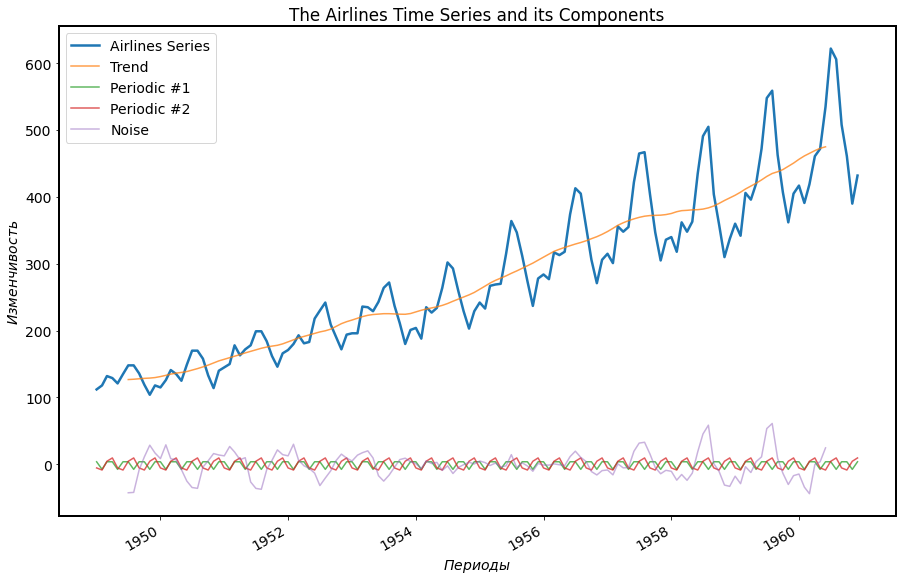

In [5]:
plt.plot(airlines['Count'], lw=2.5)
result.trend.plot(ax=plt.gca(), alpha=0.75)
periodic1.seasonal.plot(ax=plt.gca(), alpha=0.75)
periodic2.seasonal.plot(ax=plt.gca(), alpha=0.75)
result.resid.plot(ax=plt.gca(), alpha=0.5)
plt.legend(["Airlines Series", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$Периоды$")
plt.ylabel("$Изменчивость$")
plt.title("The Airlines Time Series and its Components")

Итак, по итогу визуального анализа можно сказать, что тренд восходящий, а сезонность мультипликативна. Шум колеблется в зависимости от периода: на более ранних и более поздних этапах шум имеет достаточно большие колебания. В середине графика шум наблюдается вблизи нулевых значений. Период №2 частично повторяет сезонность (поэтому можно сказать, что прослеживается их взаимосвязь). Период 1 в серии авиалиний не виден, соответственно, требуется дальнейший анализ.

### 2. Создаем матрицу траекторий

Для начала выберем размер окна. Он должен быть в интервале 2≤𝐿≤𝑁/2, где N - это количество наблюдаемых периодов временного ряда.
Поскольку в нашем случае 144 периода (len(airlines) = 144), окно должно быть не больше 72. Поставим, например, 50:

In [6]:
L = 50 

Посчитаем количество колонок в матрице траекторий:

In [7]:
K = airlines.shape[0] - L + 1
K

95

Создадим матрицу траектории, вытягивая соответствующие подсерии из ряда и складывая их в виде столбцов:

In [8]:
X = np.column_stack([airlines['Count'][i:i+L] for i in range(0,K)])

In [9]:
X

array([[112, 118, 132, ..., 355, 306, 271],
       [118, 132, 129, ..., 306, 271, 306],
       [132, 129, 121, ..., 271, 306, 315],
       ...,
       [194, 196, 196, ..., 606, 508, 461],
       [196, 196, 236, ..., 508, 461, 390],
       [196, 236, 235, ..., 461, 390, 432]], dtype=int64)

Матрица готова. Как можно заметить, первая строка матрицы - значения нашего временного ряда от 0 индекса до 94. Вторая строка - от 1 индекса до 95 и так далее со сдвигом вперед на одно значение.

Теперь посмотрим на матрицу траекторий, построив антидиагональный плот:

Text(0.5, 1.0, 'The Trajectory Matrix for the Airlines Series')

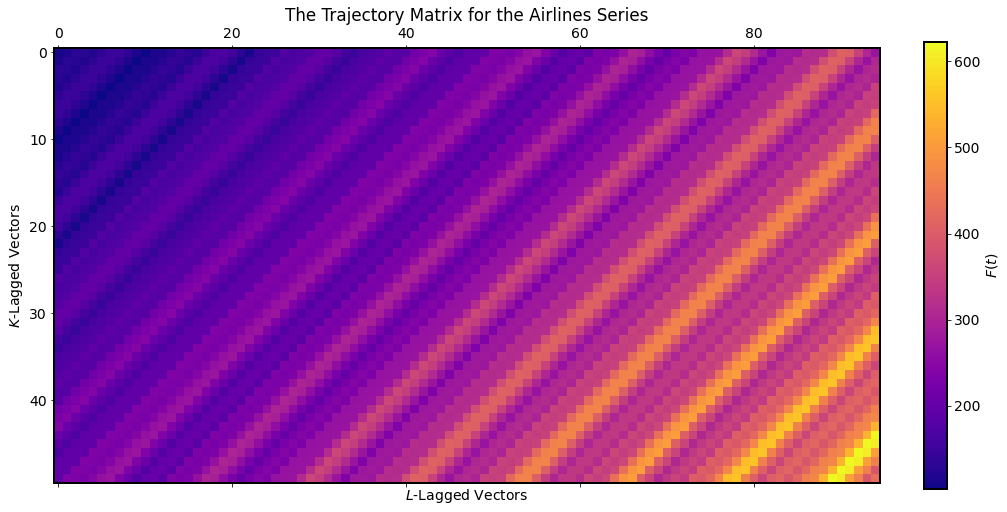

In [10]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Airlines Series")

Можно заметить схожесть значений (синий цвет и его оттенки) в левом верхнем углу и далее вправо. Они занимают около трети всего графика. Если посмотреть на матрицу, то действительно в левой части значения колеблются от 100 до 200, в то время как в правой части - есть и показатели, доходящие до 600 тысяч пассажиров в год. Тем не менее, общий цвет правой части плота малиново-оранжевый, т.е. интервал значений 300-500 тысяч. Посмотрим на матрицу и отметим, что это действительно так.  
При этом градиент заливки (если не обращать внимания на "пиксели") медленно меняется от синего до оранжево-желтого, что явно свидетельствует о плавном увеличении значений матрицы. А именно это и происходит в ряде: с каждым годом всё больше пассажиров пользуются услугами авиалиний.

### 3. Разложения матрицы траекториии

Теперь разложим матрицу траекторий и сформируем ее элементарные матрицы:

In [11]:
# Сформируем внутреннюю размерность пространства траекторий:
d = np.linalg.matrix_rank(X)


# разложим по сингулярным значениям:
U, Sigma, V = np.linalg.svd(X)  

# поскольку процедура SVD возвращает матрицу V^T, то транспонируем ее еще раз:
V = V.T 

# вычислим элементарные матрицы X, сохраняя их в многомерном массиве NumPy.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# перепроверим себя: сумма всех элементарных матриц в X_elm должна быть равна X (допускаем лишь очень небольшое отклонение)
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Всё получилось.Теперь посмотрим на первые 12 элементарных матриц:

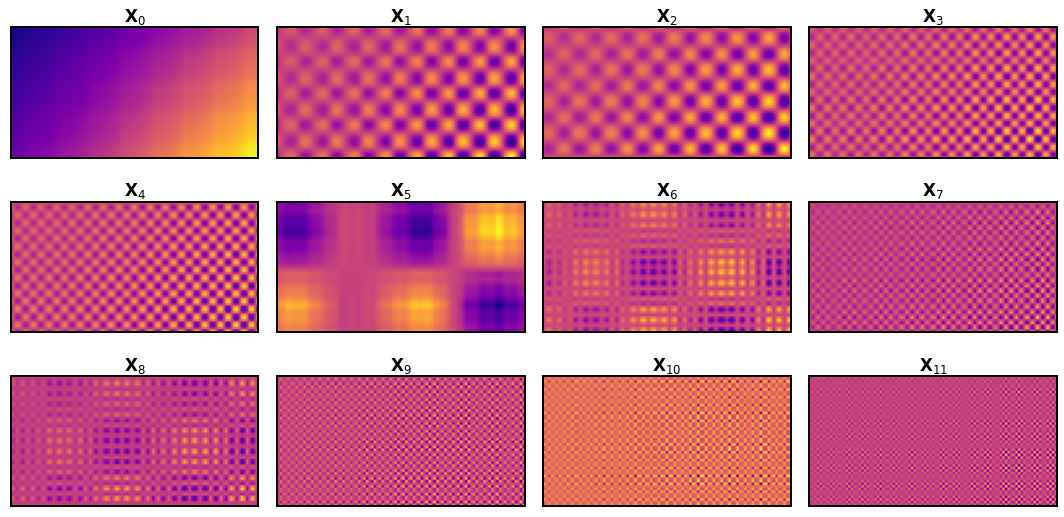

In [12]:
n = min(12, d) 
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Посмотрев на визуализации матриц  𝐗𝑖,  можно сказать, что  𝐿 - и  𝐾 -запаздывающие векторы в  𝐗0  изменяются относительно медленно по всей матрице, поэтому можно предположить, что это общий тренд. Действительно, ситуация на диаграмме 𝐗0 очень похожа на построенный ранее антидиагональный плот. Идем дальше.  
Матрицы  𝐗1  -  𝐗4 напоминают отображение шахматной доски. Это позволяет сделать вывод о периодичности изменений. Возможно, имеет место некая сезонность или просто периодичность.  
𝐗5  может находиться где-то между периодичностью и трендом.   
Начиная с матрицы  𝐗6, мы видим быстрое чередование между несколькими значениями. Есть вероятность предполагать, что эти элементарные матрицы имеют отношение к шуму в исходном временном ряду. При этом в матрицах 𝐗6 и 𝐗8 чередование происходит существенно медленнее, чем в матрицах 𝐗7, 𝐗9, 𝐗10 и далее.

Что нам могут сказать графики относительных вкладов и кумулятивных вкладов первых 12 элементарных матриц в матрицу траекторий нашего временного ряда?

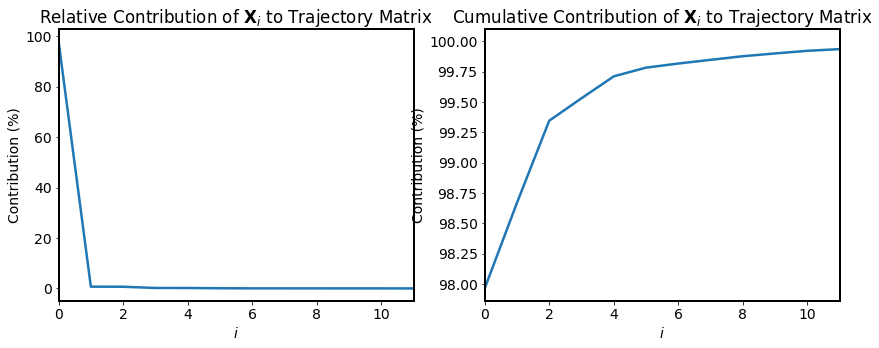

In [13]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Изучив график относительных вкладов, мы приходим к выводу, что элементарная матрица 𝐗0 вносит порядка 98% в разложение 𝐗. 𝐗1 и 𝐗2 вносят вклад оставшиеся 2%. Начиная с 𝐗3 влияния практически нет.  
Переходим к графику кумулятивных вкладов: вклад во временной ряд усиливается с каждым последующим 𝐗𝑖. При этом отметим, что минимальное значение - 98% и далее растет. Стремительный рост заканчивается на матрице 𝐗4. Далее вклад становится всё меньше. Если мы обратим внимание на 𝐗9 и 𝐗10, то заметим, что там уже вклада практически нет - изменение незначительно.

### 4. Реконструкции временных рядов

Чтобы извлечь временной ряд из элементарных матриц, мы будем использовать диагональное усреднение. Сделаем ханкелизацию:

In [14]:
def Hankelise(X):
    """
    Ханкелизация матрицы X. Возвращает H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:   # L должно быть меньше K 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

Применим и посмотрим, что получится:

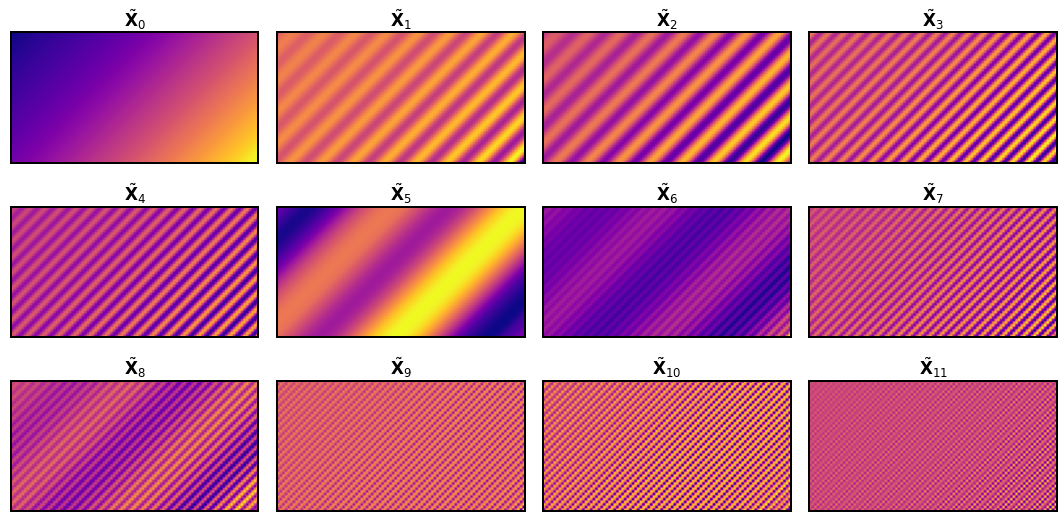

In [15]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Теперь четко видно, что $\tilde{\mathbf{X}}_0$ - тренд. $\tilde{\mathbf{X}}_1$ и $\tilde{\mathbf{X}}_2$ являются периодическими с одинаковой частотой и могут быть сгруппированы как первый периодический компонент. $\tilde{\mathbf{X}}_3$ и $\tilde{\mathbf{X}}_4$ также являются периодическими, но уже с другой частотой, соответственно, будут сгруппированы как второй периодический компонент. 
$\tilde{\mathbf{X}}_5$ пока группировать не с чем. Мы объединим все компоненты из $\tilde{\mathbf{X}}_6$ и далее как шум.  
Хотя мы определили группировку компонентов временного ряда в терминах элементарных матриц Ханкеля, мы больше не будем вычислять полную матрицу Ханкеля  $\tilde{\mathbf{X}}_𝑖$, а вместо этого вычисляем  $\tilde{\mathbf{F}}_𝑖$  непосредственно из  $\tilde{\mathbf{X}}_𝑖$. Для этого напишем функцию:

In [16]:
def X_to_TS(X_i):
    """Усредняем антидиагонали данной элементарной матрицы X_i и возвращает временной ряд."""
    # Обратный порядок столбцов X_i
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

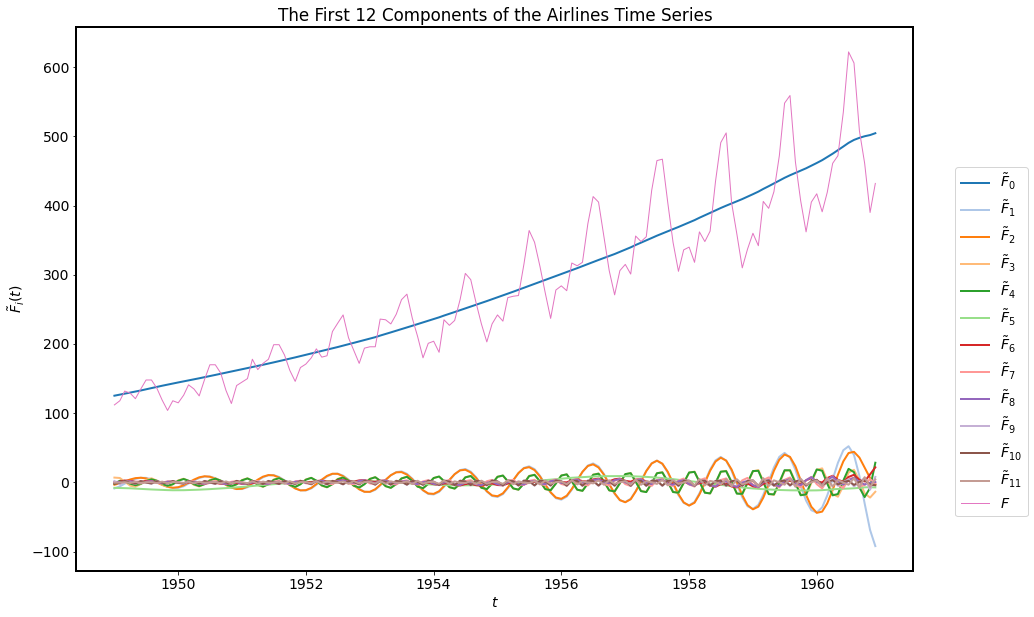

In [17]:
n = min(12,d) 

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Преобразуем элементарные матрицы прямо во временные ряды
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(airlines.index, F_i, lw=2)
    
fig.axes.plot(airlines.index, airlines.Count.values, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Airlines Time Series")
fig.legend(legend, loc=(1.05,0.1));

Согласно сделанным выше выводам, элементарные компоненты, разделенные в пространстве траекторий временного ряда, могут не совпадать или совпадать с одной интерпретируемой компонентой временного ряда. Например, $\tilde{F}_0$ похож на тренд.  
При этом $\tilde{F}_1$ и $\tilde{F}_2$ почти идентичны, за исключением границ временного ряда.  Являются ли они периодами?  
Дальше рассмотреть график не представляется возможным из-за наложения кривых.

Чтобы идти дальше, сгруппируем $\tilde{F}_2$ и $\tilde{F}_𝑖$ так, как писали выше:

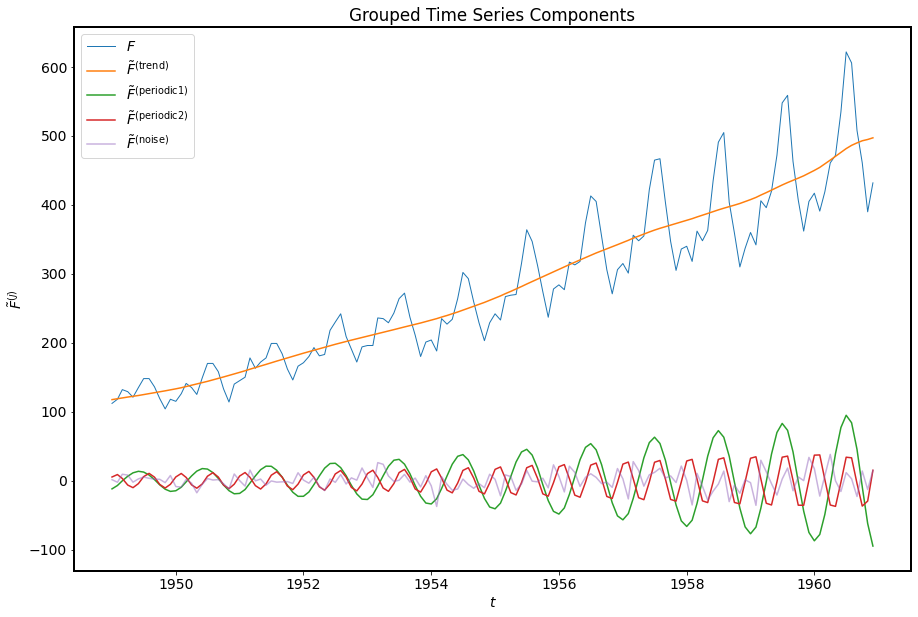

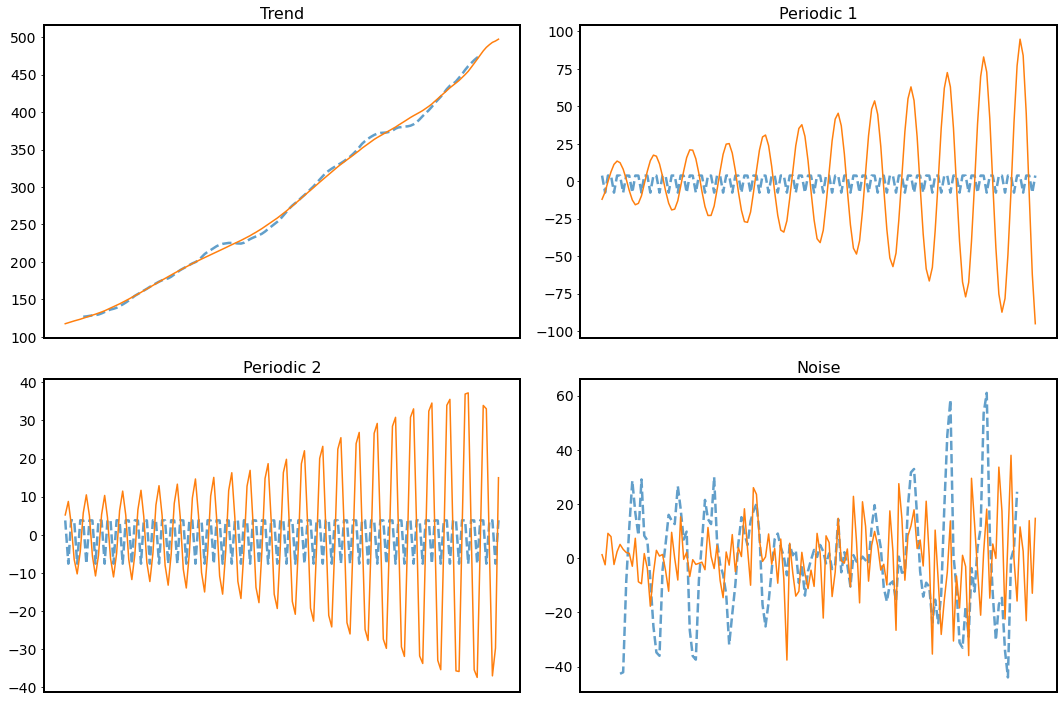

In [18]:
F_trend = X_to_TS(X_elem[[0,5]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F_noise = X_to_TS(X_elem[6:].sum(axis=0))

# Построим временной ряд для авиалиний и его отдельные компоненты сразу на одном графике
plt.plot(airlines.index, airlines.Count, lw=1)
plt.plot(airlines.index, F_trend)
plt.plot(airlines.index, F_periodic1)
plt.plot(airlines.index, F_periodic2)
plt.plot(airlines.index, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# Заводим список кортежей, чтобы мы могли создать следующий график с помощью цикла
components = [("Trend", result.trend, F_trend), 
              ("Periodic 1", periodic1.seasonal, F_periodic1),
              ("Periodic 2", periodic1.seasonal, F_periodic2),
              ("Noise", result.resid, F_noise)]

# Построим вместе и отдельные компоненты, и исходные компоненты
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(airlines.index, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(airlines.index, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

Что можно сказать: тренд описан довольно точно. Чего нельзя сказать об остальных компонентах. Если не брать в расчет шум как малоинформативное (или совсем не информативное) явление, то оставшиеся компоненты - периоды - не угаданы вообще. Тем не менее, само колебание описано достаточно верно: период 1 колеблется чуть плавнее, чем период 2. Описывающие кривые уловили эту особенность, но в остальном - полный провал.  
Это часто встречается в SSA и возникает из-за того, что в соответствии с формализмом SSA большинство типов рядов (т.е. полиномиальных, синусоидальных, экспоненциальных и т. Д.) не являются точно разделимыми. Поэтому наша попытка восстановить точный параболический тренд и периодические компоненты изначально не была ориентирована на успех.

### 5. Разделение и группировка компонентов временных рядов

Поскольку наш временной ряд оказался сложнее, визуальное разделение не помогло. Для более длинного и сложного временного ряда мы ищем метод, который количественно определяет, можно ли считать реконструированный компонент $\tilde{F}_i$ отдельным от другого компонента $\tilde{F}_j$, поэтому нам не нужно принимать решения о группировке, визуально проверяя каждый $\tilde{F}_i$.  
Поэтому построим w-корреляционную матрицу для нашего временного ряда:

In [19]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Получим все компоненты серии авиалиний и сохраним их в виде столбцов в массиве F_elem.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Сначала вычислим индивидуальные взвешенные нормы || F_i || _w, затем извлечем квадратный корень
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Вычислим матрицу w-corr. Диагональные элементы равны 1, поэтому мы можем начать с единичной матрицы, 
# где переберем все пары i и j (i! = j), отмечая, что Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

Построим график w-корреляционной матрицы:

Text(0.5, 1.0, 'The W-Correlation Matrix for the Airlines Time Series')

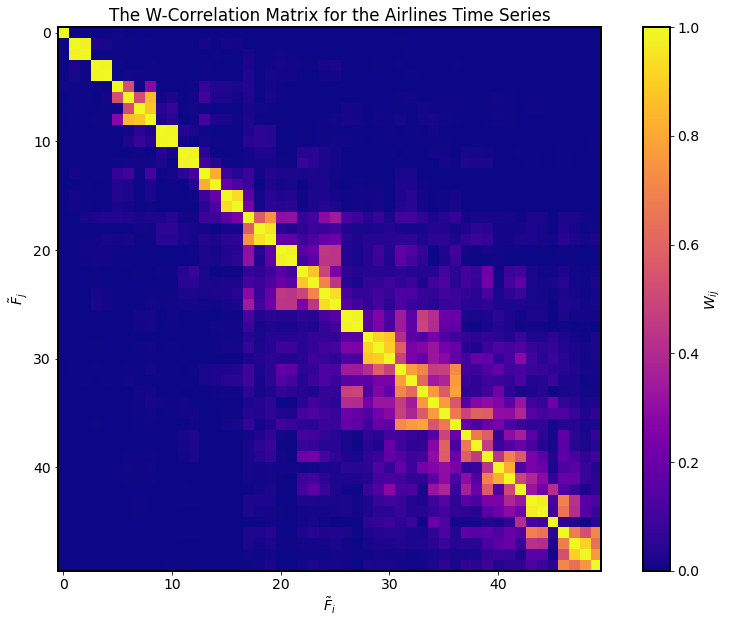

In [20]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Airlines Time Series")

Итак, мы видим достаточно сильную зашумленность, начиная с $\tilde{F}_i$ = 4,5 и далее. Особенно сильную корреляцию можно заметить в диапазоне $\tilde{F}_i$ > 17, $\tilde{F}_j$ < 17. Это естественный результат того, что шум не имеет лежащего в основе структурного компонента, который можно было бы далее отделить.

Text(0.5, 1.0, 'W-Correlation for Components 0–5')

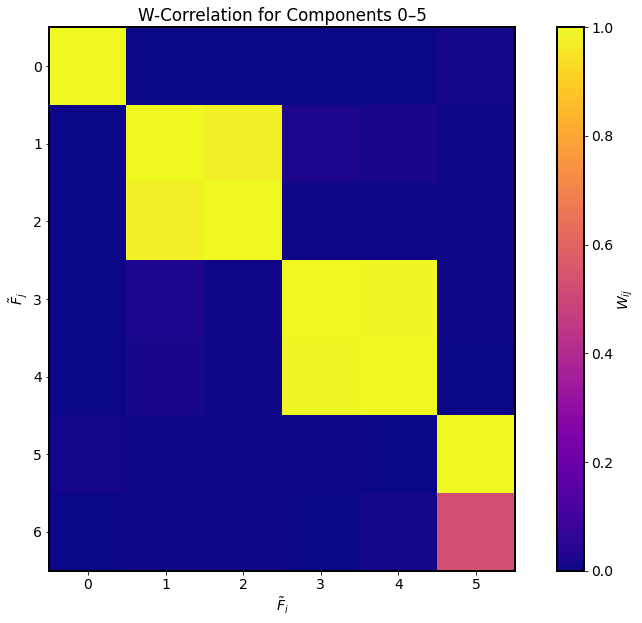

In [21]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,5.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–5")

Построив график для первых 5 компонент, можно увидеть, что действительно 1 и 2, 3 и 4 компоненты близки по корреляции. Это можно использовать для объединения периодов.

### 6. Класс Python для SSA

Перенесем сюда класс, который делает всё, что мы уже реализовали. Будем в дальнейшем использовать его.

In [22]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

### 7. Длина окна

В соответствии с заданием поиграем с длиной окна:

***L=2***

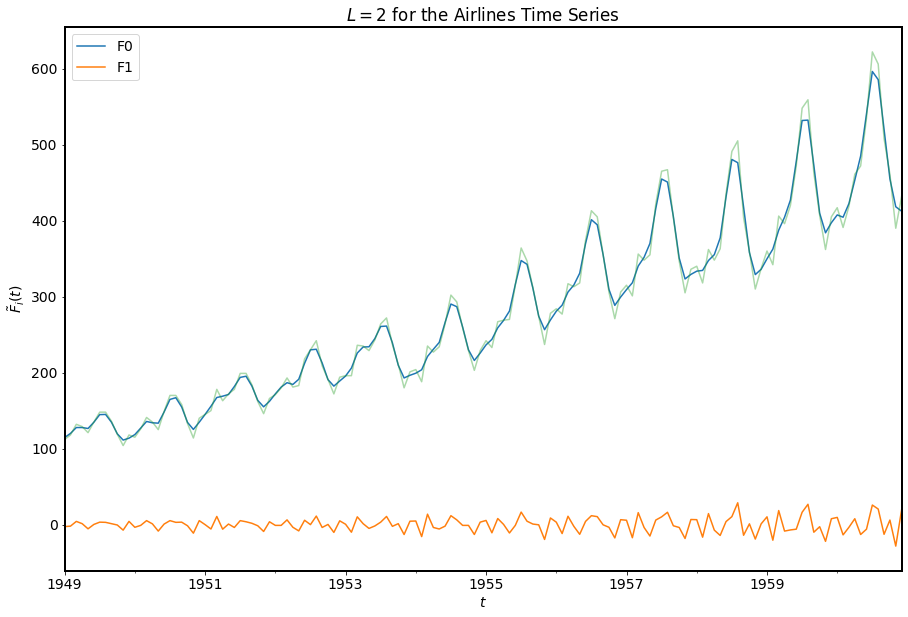

In [23]:
F_ssa_L2 = SSA(airlines['Count'], 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Airlines Time Series");

Для  𝐿=2  мы можем ожидать возврата только двух элементарных компонентов. При этом нельзя не заметить, что алгоритм SSA уже отделяет высокочастотный шум от ряда.

***L=10***

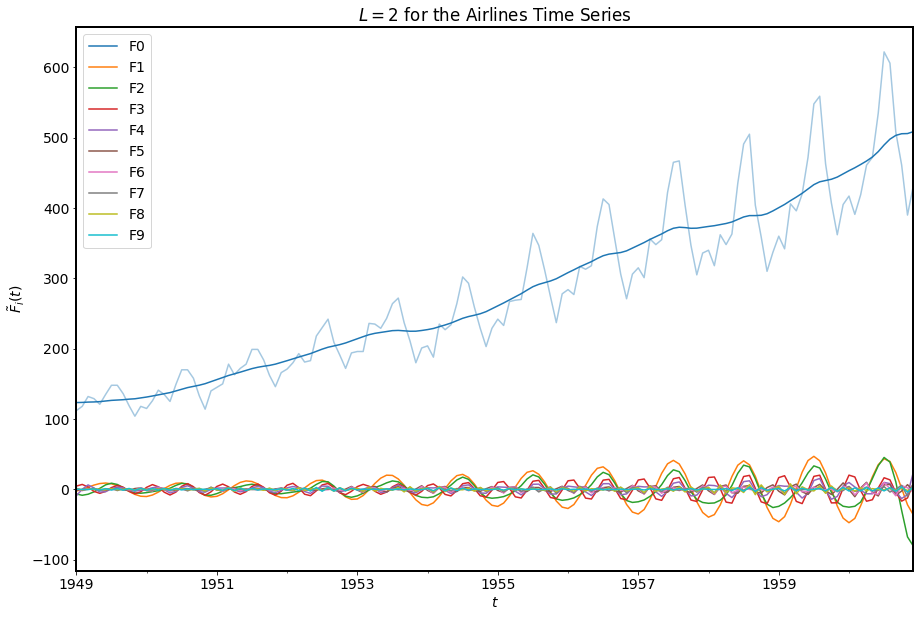

In [24]:
F_ssa_L10 = SSA(airlines['Count'], 10)
F_ssa_L10.components_to_df().plot()
F_ssa_L10.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Airlines Time Series");

$\tilde{F}_0$ теперь четко представляет собой тренд, наблюдается некоторая схожесть $\tilde{F}_1$ и $\tilde{F}_2$. Всё остальное - шум.

***L=20***

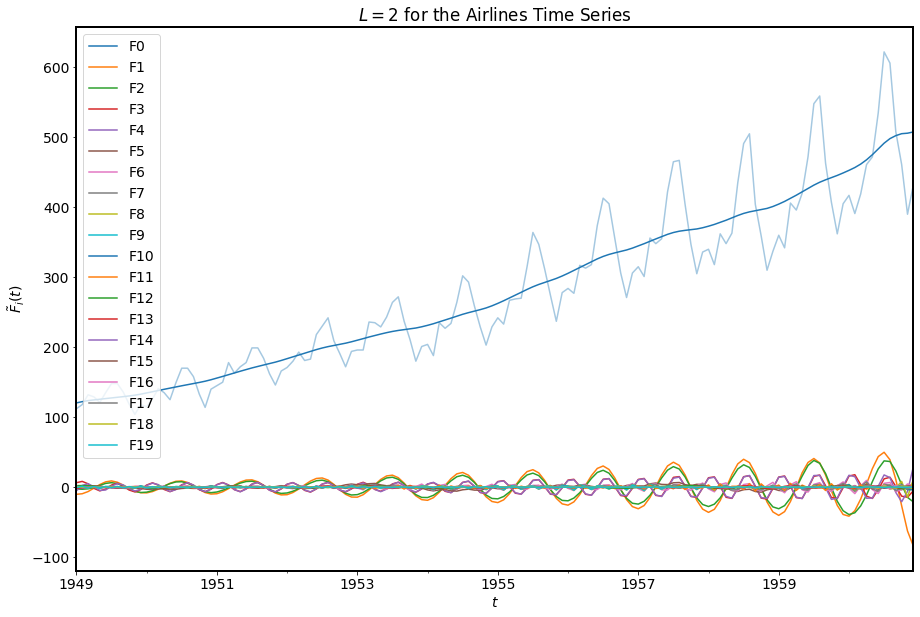

In [25]:
F_ssa_L20 = SSA(airlines['Count'], 20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Airlines Time Series");

$\tilde{F}_1$ и $\tilde{F}_2$ действительно стали повторять друг друга, исключение - конец графика. Остальное всё так же мало различимо.

Увеличим длину окна в четыре раза, и вместо того, чтобы проверять элементарные компоненты, мы рассмотрим полученную w-корреляционную матрицу и сначала примем некоторые решения о группировке.

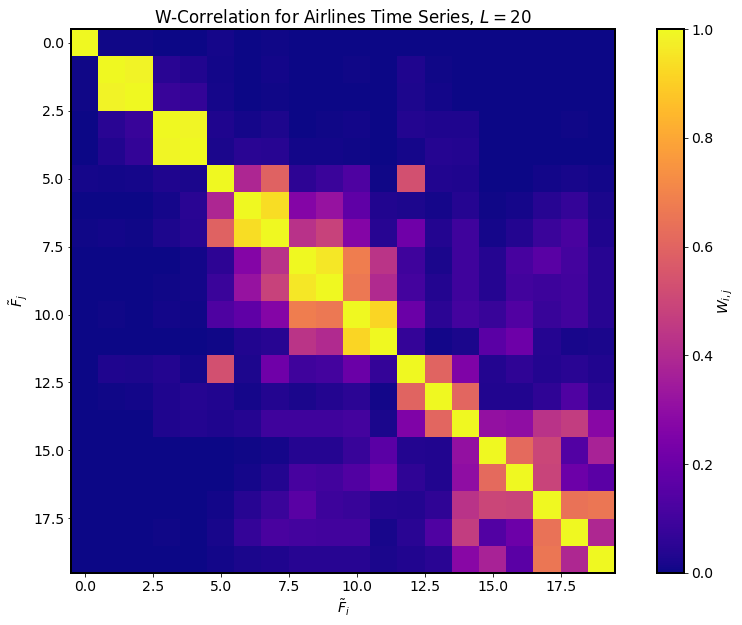

In [26]:
F_ssa_L20 = SSA(airlines['Count'], 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Airlines Time Series, $L=20$");

В данном случае с L = 20 w - корреляционная матрица практически повторила матрицу на 50 окон. Всё также предлагается объединить$\tilde{F}_1$ и $\tilde{F}_2$ ; $\tilde{F}_3$ и $\tilde{F}_4$. Дальше имеет место быть сильная корреляция - зашумленность. При этом визуально шум можно грубо разделить на 2 части: $\tilde{F}_i$ > 4 и $\tilde{F}_i$ > 11. На этих промежутках угадывается дублирование предыдущих периодов - некая цикличность шума.  
Построим выбранные группировки: 

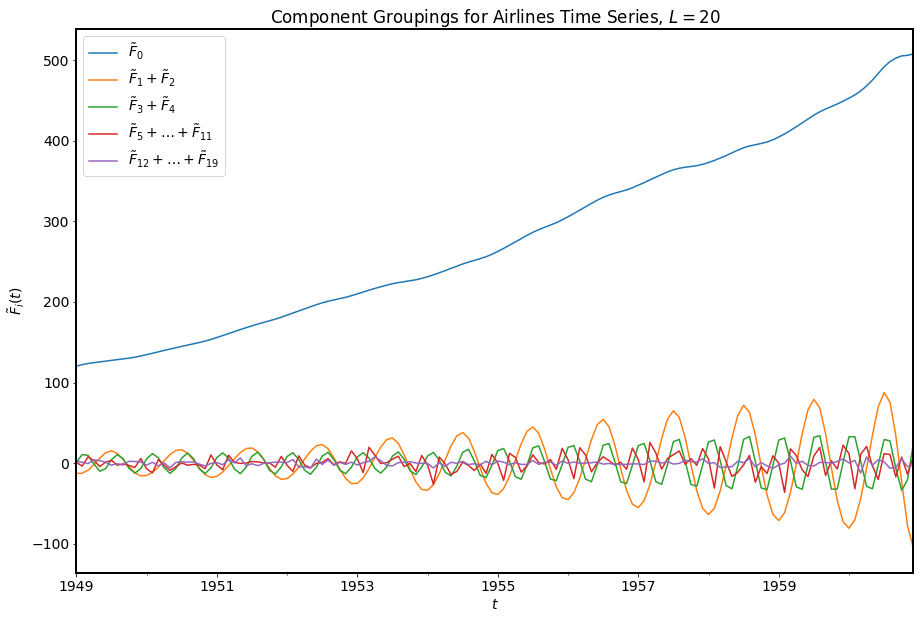

In [27]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2]).plot()
F_ssa_L20.reconstruct([3,4]).plot()
F_ssa_L20.reconstruct(slice(5,12)).plot()
F_ssa_L20.reconstruct(slice(12,20)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Airlines Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_{2}$", 
            r"$\tilde{F}_3+\tilde{F}_{4}$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{11}$",
            r"$\tilde{F}_{12}+ \ldots + \tilde{F}_{19}$",]);

Итак, окно = 20 достаточно четко показывает не только тренд, но и сезонные составляющие. Группировка $\tilde{F}_1$ и $\tilde{F}_2$ уже точнее показывает мультипликативность сезонности изначального временного ряда. $\tilde{F}_3$ + $\tilde{F}_4$ как вид несколько другой периодичности точно так же уже определяет усиление самого колебания и его частоты пд действием времени, что также не лишено смысла. Остальное воспринимается как шум.

***L=72*** (максимально возможное в нашем случае)

Поскольку на графике компонентов при таком количестве окон вряд ли что-то можно будет увидеть четко, сразу проверим w-корреляционную матрицу:

Text(0.5, 1.0, 'W-Correlation for Airlines Time Series, $L=72$')

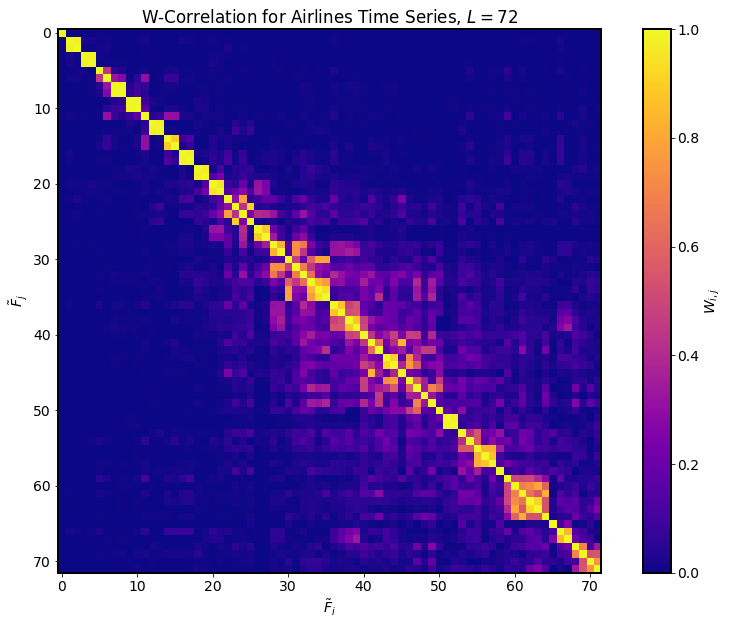

In [28]:
F_ssa_L72 = SSA(airlines['Count'], 72)
F_ssa_L72.plot_wcorr()
plt.title("W-Correlation for Airlines Time Series, $L=72$")

Как и в случае с исходным результатом $L=72$, матрица w-корреляции теперь состоит из двух отдельных блоков: $\tilde{F}_0$ - $\tilde{F}_4$ и $\tilde{F}_5$ - $\tilde{F}_{72}$. Из опыта теперь ясно, что $\tilde{F}^{\text{(signal)}} = \sum_{i=0}^4 \tilde{F}_i$ будет комбинированной трендовой и периодической компонентами ('signal'), а $\tilde{F}^{\text{(noise)}} = \sum_{i=5}^{72} \tilde{F}_i$ будет шумом:

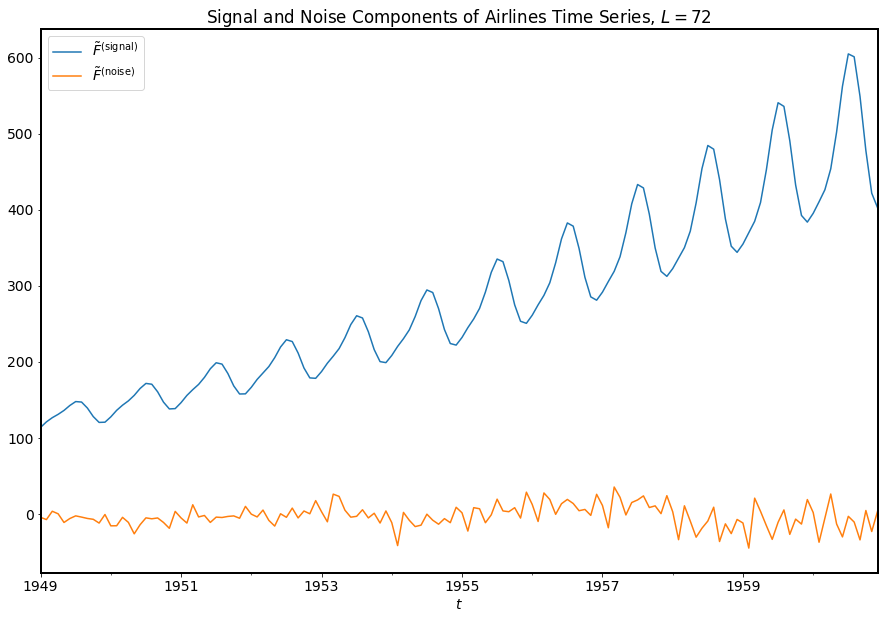

In [29]:
F_ssa_L72.reconstruct(slice(0,4)).plot()
F_ssa_L72.reconstruct(slice(5,72)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Airlines Time Series, $L = 72$")
plt.xlabel(r"$t$");

Теперь график практически идентичен изначальному. Действительно в $\tilde{F}_0$ - $\tilde{F}_4$ проявляется как общий тренд, так и сезонность. Всё, что осталось "за бортом" - шум. Построим график w-корреляции для первых 4 компонентов:

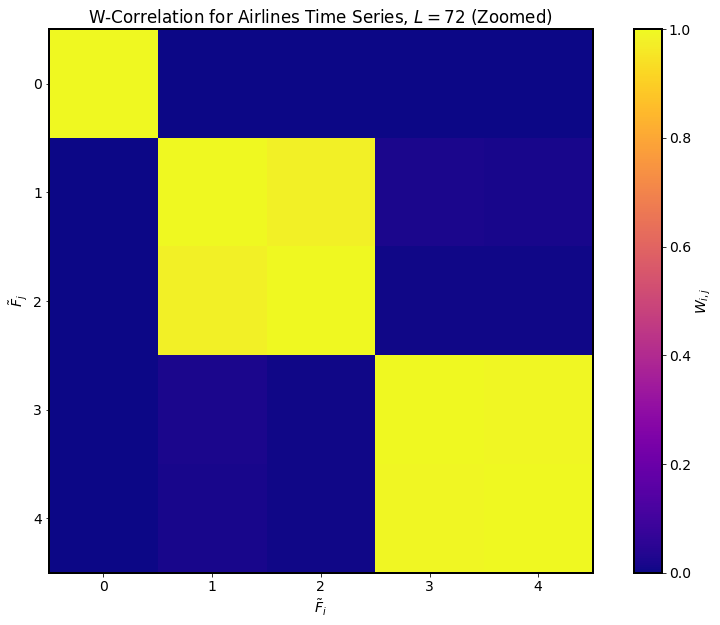

In [30]:
F_ssa_L72.plot_wcorr(max=4)
plt.title("W-Correlation for Airlines Time Series, $L=72$ (Zoomed)");

Корреляции между компонентами нет или практически нет. Чтобы понять, почему, построим их все сразу:

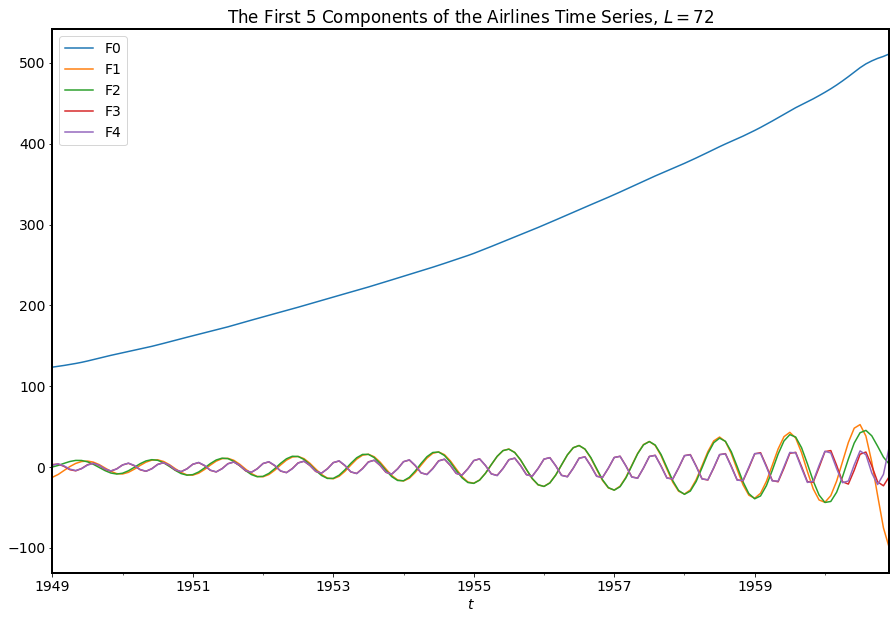

In [31]:
F_ssa_L72.components_to_df(n=5).plot()
plt.title(r"The First 5 Components of the Airlines Time Series, $L=72$")
plt.xlabel(r"$t$");

Нам открылась вполне узнаваемая картина. Практически такая же ситуация была при L=50. При максимальной длине окна компоненты временного ряда, генерируемые ведущими пятью собственными матрицами, (относительно) нечувствительны к длине окна.

### Вывод

В данной работе мы проводили анализ с помощью SSA на временном ряде с пассажиропотоком на авиалиниях США, измеряющемся в тысячах человек.  
В процессе работы мы выстраивали графики, использовали методы декомпозиции и реконструкции, отделяли лишнее и убирали шум.  
Наиболее интересна была заключительная часть, где мы перебирали длину окна. Опытным путем был выделен оптимальный размер, которым оказался изначально выбранный L=50. При меньшем размере окна мы могли выделить только основные компоненты ряда, а при максимальном размере - L=72 - выводы совпадали с первоначальными (где L=50), подтверждая тем самым, что не обязательно всегда полагаться на максимум.
Таким образом, можно сказать, что хоть SSA и не всегда подходящий метод, но он довольно эффективен для уменьшения размерности данных, т.к. полученное разложение может служить основой прогнозирования как самого ряда, так и его отдельных составляющих.